# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Machine-learning-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Dataset Parameters

In [2]:
num_images = 1 # Number of images to create for the dataset
num_bees = 4 # Maximum number of bees to include per image
IMAGE_WIDTH = 25
IMAGE_HEIGHT = 50
EX_SUB = 1
VAL_SIZE = 0.1
FILL_IMG = 0 # need to change; inpaint only works with 3-channel images
# num_sets = 1

print("Done")

Done


## Library Imports

In [3]:
from datetime import datetime
import tensorflow_datasets as tfds
import json
import os
import glob
import random
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import GEORGE_Library as GEORGE
import sys
sys.path.append("BestBGRemove")
from BestBGRemove import do_image
sys.path.append("Detection_to_XML")
from Detection_to_XML import CreateXMLfile, xml_to_csv
%matplotlib inline

print("Done")

C:\Users\khard\.conda\envs\tf\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Done


## YOLO Dataset Definition

In [4]:
'''
{
"info": info, "images": [image], "annotations": [annotation], "licenses": [license],
}
 
info{
"year": int, "version": str, "description": str, "contributor": str, "url": str, "date_created": datetime,
}
 
image{
"id": int, "width": int, "height": int, "file_name": str, "license": int, "flickr_url": str, "coco_url": str, "date_captured": datetime,
}
 
license{
"id": int, "name": str, "url": str,
}
 
annotation{
"id": int, "image_id": int, "category_id": int, "segmentation": RLE or [polygon], "area": float, "bbox": [x,y,width,height], "iscrowd": 0 or 1,
}
 
categories[{
"id": int, "name": str, "supercategory": str,
}]
'''

class img:
    def __init__(self, img_id: int, width: int, height: int, file_name: str, license: int, flickr_url: str, coco_url: str, date_captured: datetime):
        self.img_id = img_id
        self.width = width
        self.height = height
        self.file_name = file_name
        self.license = license
        self.flickr_url = flickr_url
        self.coco_url = coco_url
        self.date_captured = date_captured
 
class license:
    def __init__(self, lic_id: int, name: str, url: str):
        self.lic_id = lic_id
        self.name = name
        self.url = url
 
class bbox:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
 
class annotation:
    def __init__(self, ann_id: int, image_id: int, category_id: int, segmentation, area: float, bbox: bbox, iscrowd: bool):
        self.ann_id = ann_id
        self.image_id = image_id
        self.category_id: category_id
        self.segmentation = segmentation
        self.area = area
        self.bbox = list(vars(bbox).values())
        self.iscrowd = iscrowd
 
class category:
    def __init__(self, cat_id: int, name: str, supercategory: str):
        self.cat_id = cat_id
        self.name = name
        self.supercategory = supercategory
 
info = {
        "year": int,
        "version": str,
        "description": str,
        "contributor": str,
        "url": str,
        "date_created": datetime,
        }

print("Done")

Done


## Feeder Image Array Creation

In [5]:
train_augmented_fp = "Dataset/TrainAugmented"
val_augmented_fp = "Dataset/ValAugmented"

try:
    files = os.listdir(train_augmented_fp)
    for file in files:
        file_path = os.path.join(train_augmented_fp, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
    files = os.listdir(val_augmented_fp)
    for file in files:
        file_path = os.path.join(val_augmented_fp, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
except OSError:
    print("Error")

dataset_paths = {
                 'PD': {'none': {'path': 'Dataset/PollenDataset/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/PollenDataset/Pollen', 'label': [1, 0, 0]}},
                 'BA': {'none': {'path': 'Dataset/BeeAlarmed/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/BeeAlarmed/Pollen', 'label': [1, 0, 0]},
                        'varroa': {'path': 'Dataset/BeeAlarmed/Varroa', 'label': [0, 1, 0]},
                        'wasps': {'path': 'Dataset/BeeAlarmed/Wasps', 'label': [0, 0, 1]}},
                 'YM': {'none': {'path': 'Dataset/YangModel/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/YangModel/Pollen', 'label': [1, 0, 0]},
                        'varroa': {'path': 'Dataset/YangModel/Varroa', 'label': [0, 1, 0]}},
                }
                 # 'USU': {'none': {'path': 'Dataset/USU/None', 'label': [0, 0, 0]},
                 #         'pollen': {'path': 'Dataset/USU/Pollen', 'label': [1, 0, 0]},
                 #         'varroa': {'path': 'Dataset/USU/Varroa', 'label': [0, 1, 0]}}}

file_list = []
for dataset_path in dataset_paths:
    for dataset in dataset_paths[dataset_path]:
        [file_list.append(i) for i in glob.glob(dataset_paths[dataset_path][dataset]['path'] + '/*')]

print("Done")

Done


## Dataset Creation Loop

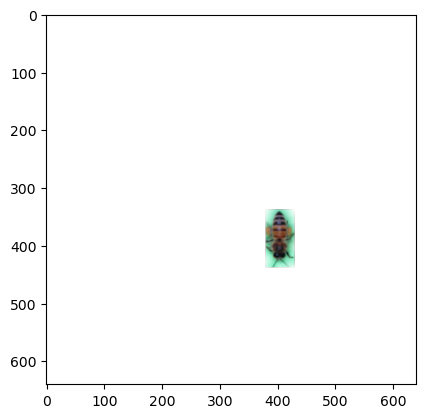

2


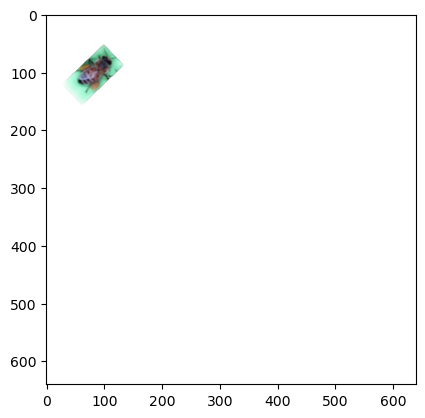

2


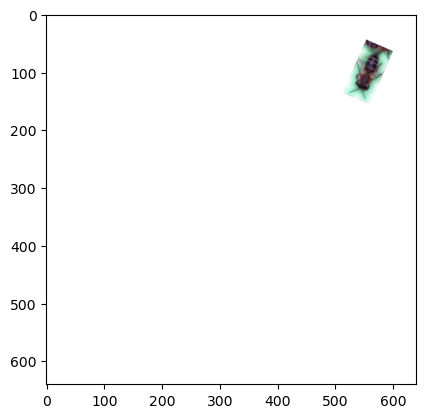

3


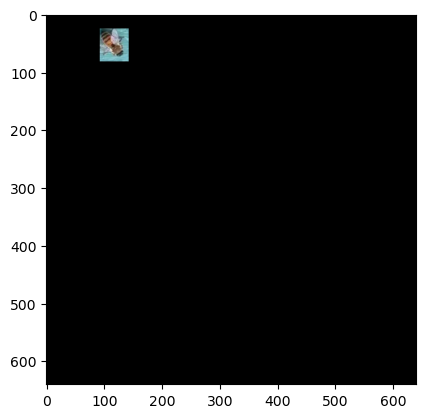

1


In [7]:
# NOTE: COCO Dataset IDs start with 1

images = []
annotations = []
licenses = []

categories = [category(1, "None", None), category(2, "Pollen", None), category(3, "Varroa", None), category(4, "Wasps", None)]

# License creation "loop"
License_Id = 1
Name = 'Attribution-NonCommercial-ShareAlike 4.0 International'
Url = 'https://creativecommons.org/licenses/by-nc-sa/4.0/'
licenses.append(license(License_Id, Name, Url))

Width = 640
Height = 640
License = 1
Flickr_url = None
Coco_url = None

for image_id in range(num_images):
    Id = image_id + 1
    File_name = Id
    Date_captured = datetime.now()

    # Feeder image usage sub-loop (annotation sub-loop)
    for bee in range(random.randint(1, num_bees)): # number of bees to include in image
        Annotation_Id = bee
        Image_id = Id

        current_bee = os.path.normpath(random.choice(file_list)) # Grab a random bee from feeder images
        category_name = os.path.dirname(current_bee).split('\\')[-1] # Get category of feeder image from containing directory
        Category_id = [i.cat_id for i in categories if i.name == category_name][0]

        image = Image.open(current_bee).convert('RGB')
        new_image = image
        if max(image.size) < min(IMAGE_WIDTH, IMAGE_HEIGHT): # Resize feeder image if required
            ind = (image.size).index(max(image.size))
            size = np.zeros(2)
            size[ind] = min(IMAGE_WIDTH, IMAGE_HEIGHT)
            size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
            new_image = image.resize((round(size[0]), round(size[1])))
        elif min(image.size) > max(IMAGE_WIDTH, IMAGE_HEIGHT):
            ind = (image.size).index(min(image.size))
            size = np.zeros(2)
            size[ind] = max(IMAGE_WIDTH, IMAGE_HEIGHT)
            size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
            new_image = image.resize((round(size[0]), round(size[1])))
        if np.array(new_image).max() <= 1: # Normalize feeder image if required
            new_image = np.array(new_image) * 255
        new_image = GEORGE.automatic_brightness_and_contrast(np.array(new_image).astype('uint8'))
        new_image = GEORGE.zoom_image(new_image)
        if EX_SUB:
            if current_bee.split("\\")[1] == "PollenDataset":
                starting_params = [159, 217, 81, [], 84, 191, 1, 9, 5.706, 3]
                new_image, _ = do_image(np.array(new_image), *starting_params)
                #Image.fromarray(img1).save(tmp_fp + current_bee.split("\\")[0] + "\\" + current_bee.split("\\")[-1].split(".")[0] + ".png")
            elif current_bee.split("\\")[1] == "BeeAlarmed":
                starting_params = [71, 203, 177, [], 134, 209, 1, 9, 3.204, 9]
                new_image, _ = do_image(np.array(new_image), *starting_params)
                #Image.fromarray(img1).save(tmp_fp + current_bee.split("\\")[0] + "\\" + current_bee.split("\\")[-1].split(".")[0] + ".png")
            elif current_bee.split("\\")[1] == "YangModel":
                pass
        new_image, new_coords = GEORGE.process_image(np.array(new_image).astype('uint8'))
        new_coords = new_coords * 640
        plt.imshow(new_image)
        plt.show()
        print(Category_id)
        str_name = []
        for coord in new_coords:
            str_name.append(str(coord).split('.')[1])
        #new_filename = "%s%s_%s_%s_%s_%s.png" % (cat, str_name[0], str_name[1], str_name[2], str_name[3], str(i + 1))
        # if current_bee in val_random_file_list:
        #     Image.fromarray(np.array(new_image).astype('uint8')).save(val_augmented_fp + "/" + new_filename,"PNG")
        # else:
        #     Image.fromarray(np.array(new_image).astype('uint8')).save(train_augmented_fp + "/" + new_filename,"PNG")

        Segmentation = None
        X = new_coords[1]
        Y = new_coords[0]
        Width = new_coords[3] - X
        Height = new_coords[2] - Y
        Area = Width * Height
        Bbox = bbox(X, Y, Width, Height)
        Iscrowd = 0 # Pretty sure this is perpetually zero for this dataset

        annotations.append(annotation(Annotation_Id, Image_id, Category_id, Segmentation, Area, Bbox, Iscrowd))
    images.append(img(Id, Width, Height, File_name, License, Flickr_url, Coco_url, Date_captured))

# with open("custom_bee_dataset.json", "w") as outfile:
#     json.dump({"info": info, "images": images, "annotations": annotations, "licenses": licenses}, outfile, indent = 4)